In [3]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy.stats import norm

In [4]:

class CausalGenerator:
    def __init__(self, graph, data,unit_vars,subunit_vars,sizes):
        self.graph = nx.DiGraph(graph)
        self.data = data
        self.processed_data = self.preprocess_data(unit_vars,subunit_vars,sizes)
        
    def preprocess_data(self,unit_vars,subunit_vars,sizes):
        # Aggregate subunit nodes
        data = {}
        
        for var in unit_vars:
            for i in range(len(sizes)):
                data[var+str(i)] = self.data[var+str(i)]
        for var in subunit_vars:
            for i in range(len(sizes)):
                s=0
                for j in range(sizes[i]):
                    s+=self.data['_'+var+str(i)+'_'+str(j)]
            data[var] = s/sizes[i]
        return data
    
    
    def generate(self, noise_dist, transition_funcs, sizes):
        generated = {}
        for node in nx.topological_sort(self.graph):
            for i in range(len(sizes)):
                x=np.random.uniform()
                parents = list(self.graph.predecessors(node))
                if not parents:
                    generated[node+str(i)] = noise_dist[node](x)
                else:
                    parent_values = [generated[p+str(i)] for p in parents]
                    generated[node+str(i)] = transition_funcs[node](*parent_values) + noise_dist[node](x)
        
        # Convert to pandas DataFrame
        return generated
        

In [5]:
import json

def load_data_from_json(file_path):
    """
    Load data from a JSON file and return it as a dictionary.
    
    :param file_path: Path to the JSON file
    :return: Dictionary containing the loaded data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None



In [6]:
data = load_data_from_json('data/sampled_data.json')


Data successfully loaded from data/sampled_data.json


In [7]:

# Example usage:
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]

unit_vars = ['a', 'c', 'e']
subunit_vars = ['d', 'b']
sizes = [50]*50

generator = CausalGenerator(graph, data,unit_vars,subunit_vars,sizes)
noise_dist = {
    'a': lambda x: norm.ppf(x),
    '_b': lambda x: norm.ppf(x, loc=0, scale=1),
    'c': lambda x: norm.ppf(x, loc=0, scale=1),
    '_d': lambda x: norm.ppf(x, loc=0, scale=1),
    'e': lambda x: norm.ppf(x, loc=0, scale=1)
}

transition_funcs = {
    '_b': lambda a: (a+1)**2,
    'c': lambda a, b: a**3 + (b+1)**2,
    '_d': lambda b, c: (b+1)**2 - c**3,
    'e': lambda c, d: c + (d+1)**2
}

In [8]:

generated_data = generator.generate(noise_dist, transition_funcs,sizes)

In [9]:
print(generated_data)


{'a0': 0.6700167322774905, 'a1': -1.1358844858736483, 'a2': -1.7317417865251525, 'a3': -0.17242811831294452, 'a4': 0.8363049526825354, 'a5': 1.3974797327118818, 'a6': 0.7985337484749364, 'a7': -1.1125999833669844, 'a8': 0.3620989429219821, 'a9': 0.48678464627149337, 'a10': -1.1704171542472823, 'a11': 0.050945740525519166, 'a12': -0.5399568090087636, 'a13': -0.13596490368400077, 'a14': 0.48908679540320427, 'a15': -1.022022638594663, 'a16': -0.07301480164795589, 'a17': -0.6374089532485044, 'a18': -0.35773711899014193, 'a19': 1.1751273160033593, 'a20': -0.24246452478706093, 'a21': 2.713155919756449, 'a22': 0.7589409265349478, 'a23': 1.9449206484205104, 'a24': 0.7864074585259626, 'a25': 1.4157499619433684, 'a26': 0.04638347972514824, 'a27': 0.9357427640833468, 'a28': -0.06372380352580637, 'a29': 0.9780254880343114, 'a30': 1.274225705803259, 'a31': 0.9683739959190185, 'a32': 0.8660415108997868, 'a33': -0.960066684796941, 'a34': -0.7340951833255674, 'a35': 1.286897006092893, 'a36': -0.507063

In [10]:
# Generate arrays for each variable
a_array = [generated_data[f'a{k}'] for k in range(len(sizes))]
b_array = [generated_data[f'_b{k}'] for k in range(len(sizes))]
c_array = [generated_data[f'c{k}'] for k in range(len(sizes))]
d_array = [generated_data[f'_d{k}'] for k in range(len(sizes))]
e_array = [generated_data[f'e{k}'] for k in range(len(sizes))]

# Print the arrays
print("a arrays:", a_array)
print("b arrays:", b_array)
print("c arrays:", c_array)
print("d arrays:", d_array)
print("e arrays:", e_array)


a arrays: [0.6700167322774905, -1.1358844858736483, -1.7317417865251525, -0.17242811831294452, 0.8363049526825354, 1.3974797327118818, 0.7985337484749364, -1.1125999833669844, 0.3620989429219821, 0.48678464627149337, -1.1704171542472823, 0.050945740525519166, -0.5399568090087636, -0.13596490368400077, 0.48908679540320427, -1.022022638594663, -0.07301480164795589, -0.6374089532485044, -0.35773711899014193, 1.1751273160033593, -0.24246452478706093, 2.713155919756449, 0.7589409265349478, 1.9449206484205104, 0.7864074585259626, 1.4157499619433684, 0.04638347972514824, 0.9357427640833468, -0.06372380352580637, 0.9780254880343114, 1.274225705803259, 0.9683739959190185, 0.8660415108997868, -0.960066684796941, -0.7340951833255674, 1.286897006092893, -0.5070638607366963, 0.10397509973186499, -1.0557371377417037, -0.4446311574777314, 1.5996756822781704, 0.2688119232534052, -0.10655432232468254, -1.7966882883718789, 0.608008452999644, -0.6817833804200775, -0.3502988661486307, -0.17838331986710673

In [11]:
original_e = [data['e'+str(k)] for k in range(len(sizes))]

In [12]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import quad


In [13]:

def kl_divergence(p, q):
    def integrand(x):
        px = p(x)
        qx = q(x)
        # Avoid log(0) by adding a small epsilon
        epsilon = 1e-10
        return np.where((px > 0) & (qx > 0),
                        px * (np.log(px + epsilon) - np.log(qx + epsilon)),
                        0)
    
    result, _ = quad(integrand, -np.inf, np.inf, limit=1000)
    return result


In [14]:

def kl_divergence(p, q, bandwidth='scott'):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux,
    en utilisant l'estimation de densité par noyau.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :param bandwidth: Méthode pour estimer la largeur de bande ('scott', 'silverman' ou un nombre)
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Estimation de densité par noyau
    kde_p = gaussian_kde(p, bw_method=bandwidth)
    kde_q = gaussian_kde(q, bw_method=bandwidth)
    
    # Créez un espace d'échantillonnage
    x = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 10000)
    
    # Estimez les densités
    p_density = kde_p(x)
    q_density = kde_q(x)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_density += epsilon
    q_density += epsilon
    
    # Normalisez les densités
    p_density /= np.sum(p_density)
    q_density /= np.sum(q_density)
    
    # Calculez la divergence KL
    return np.sum(p_density * np.log(p_density / q_density))

In [15]:

# Select two arrays for comparison
array1 = e_array  # First array from e_arrays
array2 = [data[f'e{i}'] for i in range(50)]  # Second array from the original data

arrayA = [data[f'a{i}'] for i in range(50)]  # Second array from the original data
arrayB = [np.mean(np.array([data[f'_b{i}_{j}'] for j in range(50)])) for i in range(50)]  # Second array from the original data
arrayC = [data[f'c{i}'] for i in range(50)]  # Second array from the original data




In [16]:

# Compute KL divergence
kl_div = kl_divergence(array1, array2)

# Print the KL divergence
print(f"KL divergence between the two arrays: {kl_div}")
 # high kl div okay
 
kl_div = kl_divergence(arrayA, a_array)
print(f"KL divergence between the two arrays A: {kl_div}")

kl_div = kl_divergence(arrayB, b_array)
print(f"KL divergence between the two arrays B: {kl_div}")

kl_div = kl_divergence(arrayC, c_array)
print(f"KL divergence between the two arrays C: {kl_div}")

KL divergence between the two arrays: 0.284881096966491
KL divergence between the two arrays A: 0.05390546790361114
KL divergence between the two arrays B: 0.06482447907429162
KL divergence between the two arrays C: 0.1045902148751805


/tmp/ipykernel_8832/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_8832/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


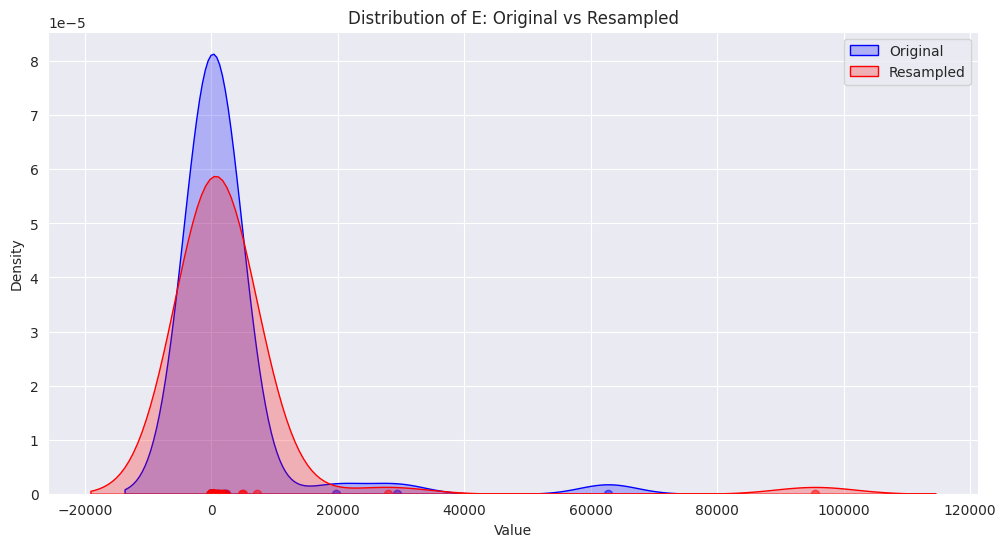

/tmp/ipykernel_8832/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_8832/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


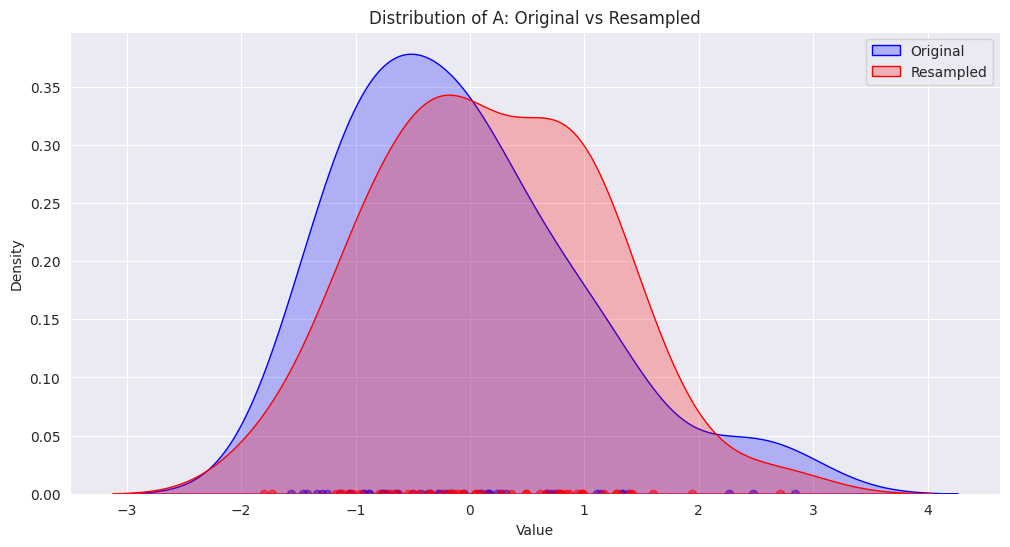

/tmp/ipykernel_8832/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_8832/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


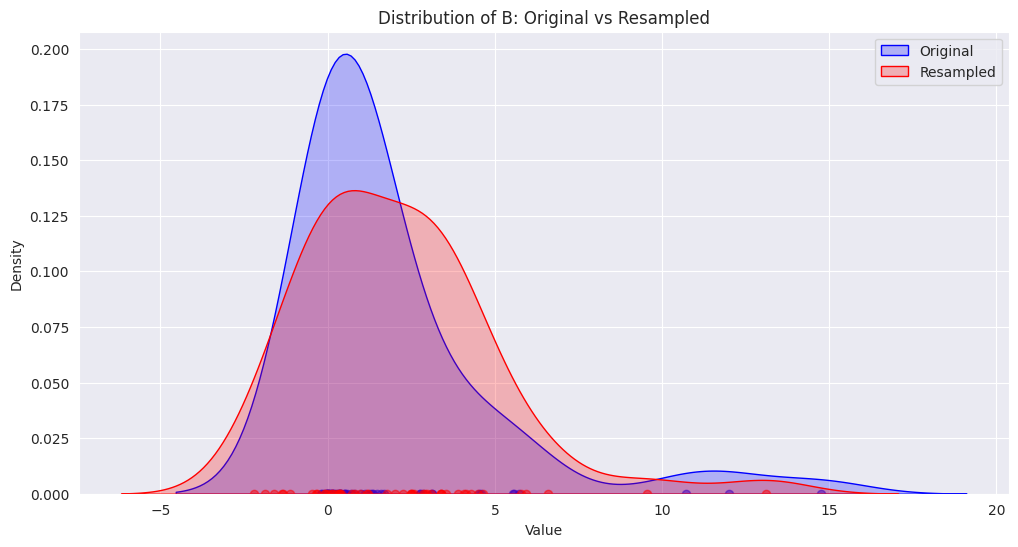

/tmp/ipykernel_8832/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_8832/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


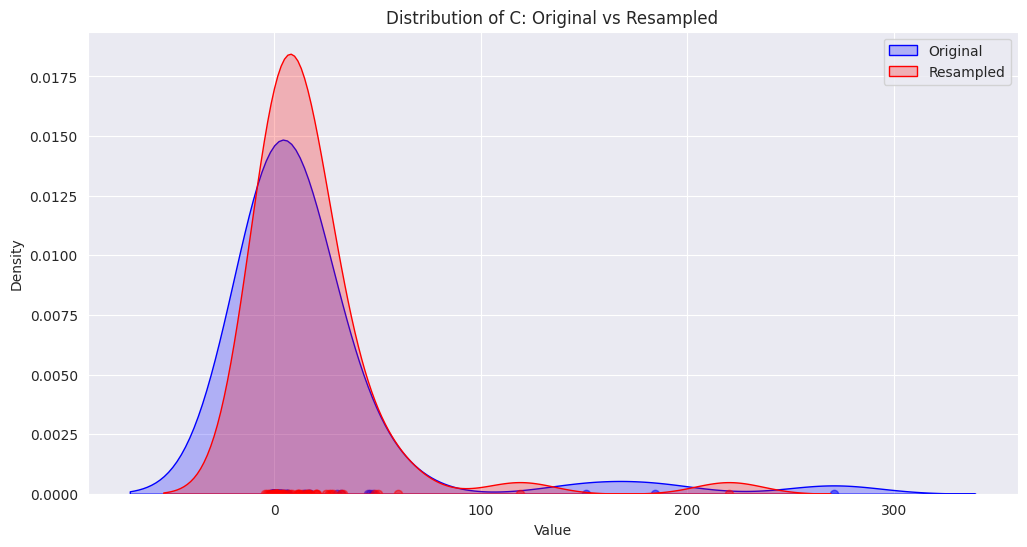

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_arrays_with_kde(original, resampled, title):
    plt.figure(figsize=(12, 6))
    
    # Plot original data
    sns.kdeplot(original, shade=True, color="blue", label="Original")
    plt.scatter(original, [0]*len(original), color="blue", alpha=0.5)
    
    # Plot resampled data
    sns.kdeplot(resampled, shade=True, color="red", label="Resampled")
    plt.scatter(resampled, [0]*len(resampled), color="red", alpha=0.5)
    
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot for E
plot_arrays_with_kde(array2, array1, "Distribution of E: Original vs Resampled")

# Plot for A
plot_arrays_with_kde(arrayA, a_array, "Distribution of A: Original vs Resampled")

# Plot for B
plot_arrays_with_kde(arrayB, b_array, "Distribution of B: Original vs Resampled")

# Plot for C
plot_arrays_with_kde(arrayC, c_array, "Distribution of C: Original vs Resampled")


In [18]:
def experiment(n):
    kldivs= []
    for k in range(n):
        # Example usage:
        graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
        data = load_data_from_json(f'data/sampled_data_{k}.json')
        print(str(k) + " is in progress")
        
        unit_vars = ['a', 'c', 'e']
        subunit_vars = ['d', 'b']
        sizes = [50]*50
        
        generator = CausalGenerator(graph, data,unit_vars,subunit_vars,sizes)
        noise_dist = {
            'a': lambda x: norm.ppf(x),
            '_b': lambda x: norm.ppf(x, loc=0, scale=1),
            'c': lambda x: norm.ppf(x, loc=0, scale=1),
            '_d': lambda x: norm.ppf(x, loc=0, scale=1),
            'e': lambda x: norm.ppf(x, loc=0, scale=1)
        }
        
        transition_funcs = {
            '_b': lambda a: (a+1)**2,
            'c': lambda a, b: a**3 + (b+1)**2,
            '_d': lambda b, c: (b+1)**2 - c**3,
            'e': lambda c, d: c + (d+1)**2
        }
        
            
        generated_data = generator.generate(noise_dist, transition_funcs,sizes)

            # Generate arrays for each variable
        a_array = [generated_data[f'a{k}'] for k in range(len(sizes))]
        b_array = [generated_data[f'_b{k}'] for k in range(len(sizes))]
        c_array = [generated_data[f'c{k}'] for k in range(len(sizes))]
        d_array = [generated_data[f'_d{k}'] for k in range(len(sizes))]
        e_array = [generated_data[f'e{k}'] for k in range(len(sizes))]
            
            
        # Select two arrays for comparison
        array1 = e_array  # First array from e_arrays
        array2 = [data[f'e{i}'] for i in range(50)]  # Second array from the original data
        
        arrayA = [data[f'a{i}'] for i in range(50)]  # Second array from the original data
        arrayB = [np.mean(np.array([data[f'_b{i}_{j}'] for j in range(50)])) for i in range(50)]  # Second array from the original data
        arrayC = [data[f'c{i}'] for i in range(50)]  # Second array from the original data
        
        arrayD = [np.mean(np.array([data[f'_d{i}_{j}'] for j in range(50)])) for i in range(50)]  # Second array from the original data
        
        kldiv = {'c': kl_divergence(arrayC, c_array), 'b': kl_divergence(arrayB, b_array), 'a': kl_divergence(arrayA, a_array), 'd': kl_divergence(arrayD, d_array), 'e': kl_divergence(array2, array1)}
        
        
        kldivs.append(kldiv)
        
    return kldivs





    

In [19]:
kldivs = experiment(100)

Data successfully loaded from data/sampled_data_0.json
0 is in progress
Data successfully loaded from data/sampled_data_1.json
1 is in progress
Data successfully loaded from data/sampled_data_2.json
2 is in progress
Data successfully loaded from data/sampled_data_3.json
3 is in progress
Data successfully loaded from data/sampled_data_4.json
4 is in progress
Data successfully loaded from data/sampled_data_5.json
5 is in progress
Data successfully loaded from data/sampled_data_6.json
6 is in progress
Data successfully loaded from data/sampled_data_7.json
7 is in progress
Data successfully loaded from data/sampled_data_8.json
8 is in progress
Data successfully loaded from data/sampled_data_9.json
9 is in progress
Data successfully loaded from data/sampled_data_10.json
10 is in progress
Data successfully loaded from data/sampled_data_11.json
11 is in progress
Data successfully loaded from data/sampled_data_12.json
12 is in progress
Data successfully loaded from data/sampled_data_13.json
13

/tmp/ipykernel_8832/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_8832/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_8832/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_8832/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, a

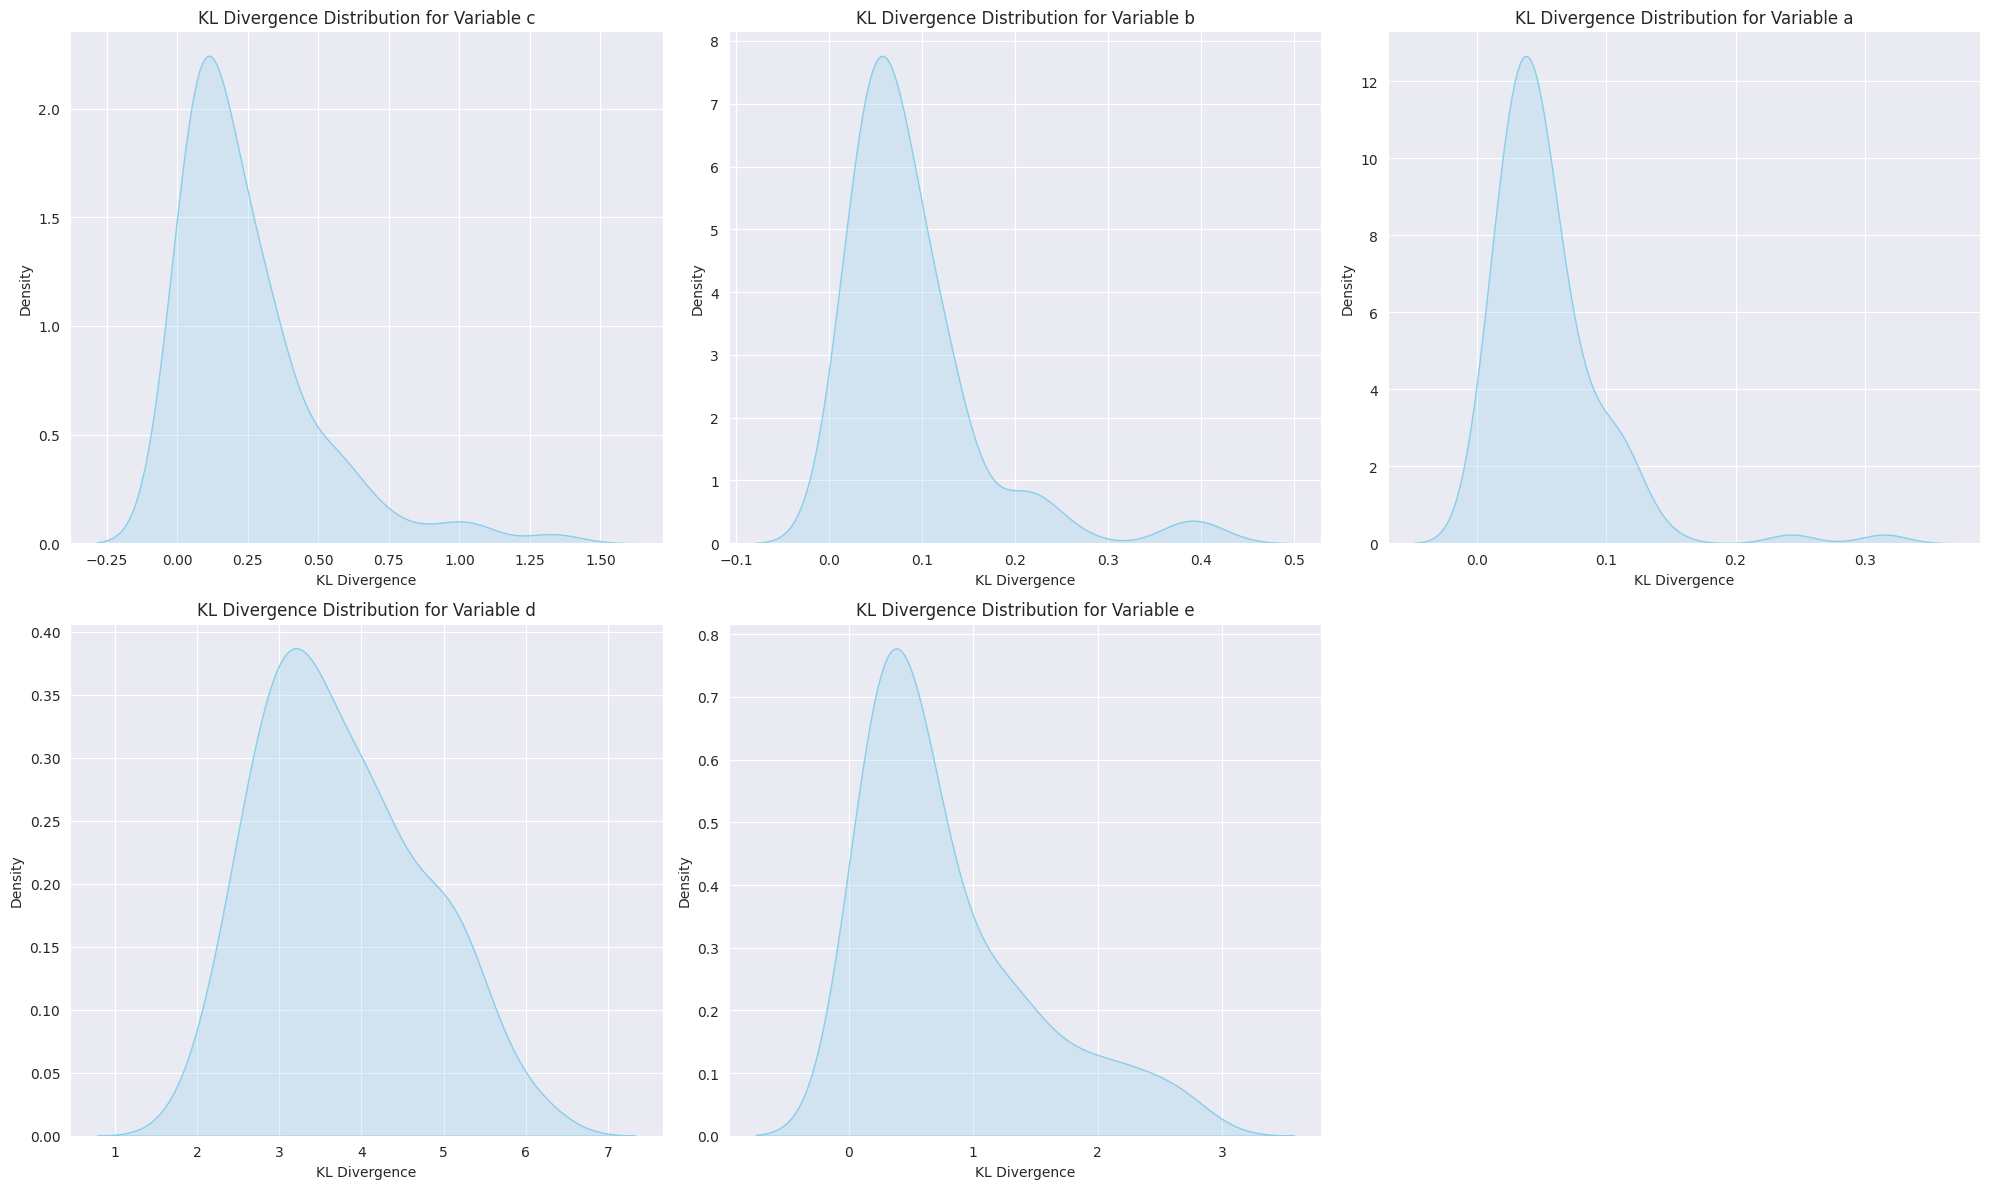

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
variables = list(kldivs[0].keys())  # Assuming kldivs is a list of dictionaries

# Create subplots for each variable
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    # Extract KL divergence values for the current variable
    kl_values = [kldiv[var] for kldiv in kldivs]
    
    # Create a KDE plot for the current variable
    sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
    
    # Customize the subplot
    axes[i].set_title(f'KL Divergence Distribution for Variable {var}')
    axes[i].set_xlabel('KL Divergence')
    axes[i].set_ylabel('Density')

# Remove the empty subplot
fig.delaxes(axes[5])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [21]:
import numpy as np

# Calculate mean and standard deviation for each variable
for var in variables:
    kl_values = [kldiv[var] for kldiv in kldivs]
    mean = np.mean(kl_values)
    std = np.std(kl_values)
    print(f"Variable {var}:")
    print(f"  Mean KL Divergence: {mean:.4f}")
    print(f"  Standard Deviation: {std:.4f}")
    print()


Variable c:
  Mean KL Divergence: 0.2457
  Standard Deviation: 0.2435

Variable b:
  Mean KL Divergence: 0.0883
  Standard Deviation: 0.0739

Variable a:
  Mean KL Divergence: 0.0545
  Standard Deviation: 0.0444

Variable d:
  Mean KL Divergence: 3.7590
  Standard Deviation: 0.9670

Variable e:
  Mean KL Divergence: 0.7984
  Standard Deviation: 0.6828

